## Sensitivity Analysis of Business Risk Models
- this notebook is based on the article "A Quantum Algorithm for the Sensitivity Analysis of Business Risks", see arXiv:2103.05475
- we construct a risk model with 2 nodes (risk items) and 1 transition (a node triggers another)
- we consider costs for each risk item and a limit for the total costs
- we are interested in the probability that the costs reach a limit
- the probabilities of the nodes and transitions can be changed by parameters
- we want to find a parameter that leads to a specific probability
- typically, we want to find a parameter that leads to a probability that is too high for our business

In [19]:
import pygrnd
from pygrnd.qc.helper import *
from pygrnd.qc.brm import *
from pygrnd.qc.brm_test import *
from pygrnd.qc.brm_oracle import *
from pygrnd.qc.QAE import *
from pygrnd.qc.parallelQAE import *
from qiskit.visualization import plot_histogram

#### Definition of a risk model
- we consider the basic definition of a risk model
- probabilities of nodes and edges cannot be changed in this basic model
- more details are in the notebook risk_model.ipynb

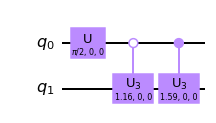

In [20]:
nodes = ['0','1']
edges=[('0','1')] 
probsNodes={'0':0.5,'1':0.3} 
probsEdges={('0','1'):0.3} 

model,mat=brm(nodes, edges, probsNodes, probsEdges)
model.draw(output='mpl')

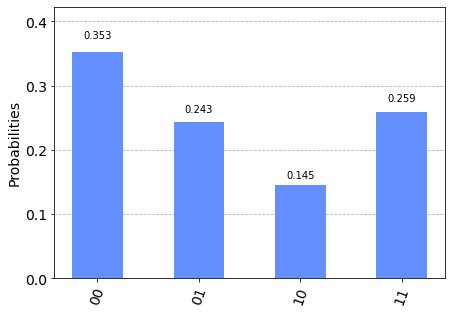

In [21]:
model.measure_all()
backend = Aer.get_backend('qasm_simulator')
job = execute(model, backend, shots=10000)
counts=job.result().get_counts()
plot_histogram(counts)

#### Risk models with cost limits and parameters that can be changed
- we extend the basic risk model by costs (integer values) for each risk item and a limit for the total costs
- we also allow each parameter to be changed
- for instance, the probability of node 0 can be changed from 0.5 to 0.55
- note that only one parameter can be changed at a time, i.e., we do not consider combinations

In [22]:
nodes = ['0','1']
edges=[('0','1')] 
probsNodes={'0':0.5,'1':0.3} 
probsEdges={('0','1'):0.3} 
probsNodesModified={'0':0.55,'1':0.8} 
probsEdgesModified={('0','1'):0.35} 

costsNodes = {'0':1,'1':1} # integer values
limit=2 # integer value

- construct a circuit with quantum register t, q, costs and limit 
- each qubit of q represents a risk item (0=off, 1=triggered)
- the register t can be used to change the probabilities
- the necessary states of t for changing the probabilities are automatically generated (node and edge mapping)
- the costs of the triggered risk items are summed up in the costs register
- the limit is subtracted from the total costs
- if the result is non-negative then we mark the limit qubit meaning that the limit was reached
- the size of the costs register is also automatically chosen

qubits model= 7
node mapping= {'0': '01', '1': '10'}
edge mapping= {('0', '1'): '11'}


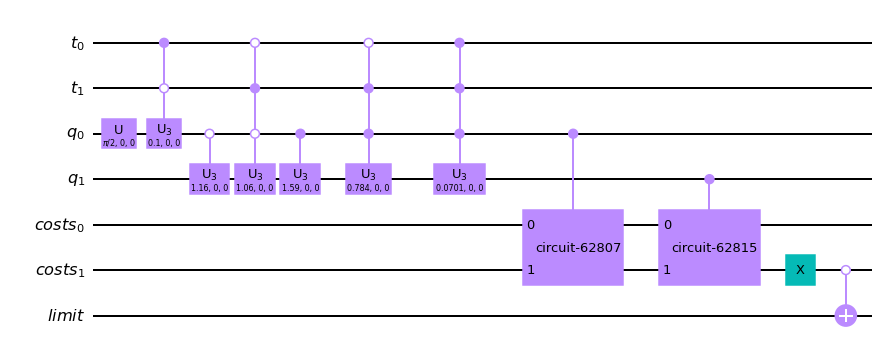

In [23]:
model,mat,nodeMapping,edgeMapping,requiredQubits=brmWithModifications(nodes, edges, probsNodes, probsEdges, probsNodesModified, probsEdgesModified,model2gate=False)
addCostsAndLimitToRiskModelCircuit(model, nodes, costsNodes, limit)
print("qubits model=",len(model.qubits))
print("node mapping=",nodeMapping)
print("edge mapping=",edgeMapping)
display(model.draw(output='mpl'))

- for each parameter, which can be changed, we can generate the modified model
- these models can be used to and generate the corresponding basic circuit
- the circuit has the same structure as the unchanged basic model
- the parameters of the rotations are changed according to the modified probabilities

{'0': 0.5, '1': 0.8}
{('0', '1'): 0.3}


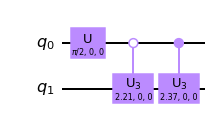

In [24]:
modification='10'
nodes2,edges2,probsNodes2,probsEdges2=getModelWithSpecificModification(nodes, edges, probsNodes, probsEdges, probsNodesModified, probsEdgesModified, nodeMapping, edgeMapping, requiredQubits, modification)
print(probsNodes2)
print(probsEdges2)
qc,mat=brm(nodes2, edges2, probsNodes2, probsEdges2)
qc.draw(output='mpl')

- for this small example, we can use this method to generate all modified circuits
- we use these circuits to compare the histograms for all possible modifications

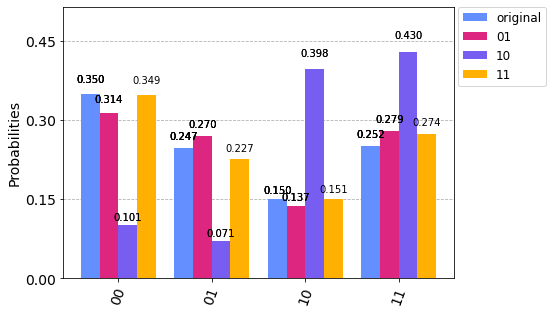

In [25]:
countsMod=[]
labelsMod=[]
for modString in ['original']+list(nodeMapping)+list(edgeMapping):

    modification=None
    if modString in nodeMapping:
        modification=nodeMapping[modString]
    elif modString in edgeMapping:
        modification=edgeMapping[modString]

    nodes2,edges2,probsNodes2,probsEdges2=getModelWithSpecificModification(nodes, edges, probsNodes, probsEdges, probsNodesModified, probsEdgesModified, nodeMapping, edgeMapping, requiredQubits, modification)
    model3,mat3=brm(nodes2, edges2, probsNodes2, probsEdges2, model2gate=False)
    model3.measure_all()

    backend = Aer.get_backend('qasm_simulator')
    job = execute(model3, backend,shots=100000)
    counts=job.result().get_counts()
    countsMod.append(counts)
    if not(modification==None):
        labelsMod.append(modification)
    else:
        labelsMod.append(modString)

plot_histogram(countsMod,legend=labelsMod)

- instead of generating basic models with modified probabilities, we can also use the circuit with the modification qubits
- we compare the result of both methods for changing the probability of node 1, corresponding to modification setting 10

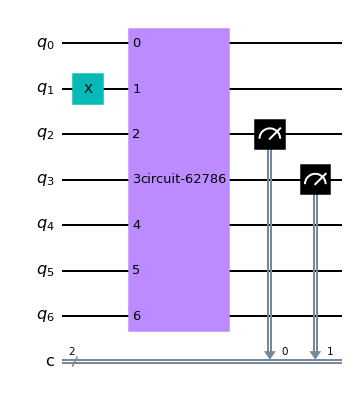

In [26]:
qr=QuantumRegister(model.num_qubits,'q')
cr=ClassicalRegister(len(nodes),'c')
qc=QuantumCircuit(qr,cr)
qc.x(qr[1])
qc.append(model.to_gate(),qr)
qc.measure(qr[requiredQubits:requiredQubits+len(nodes)],cr)
qc.draw(output='mpl')

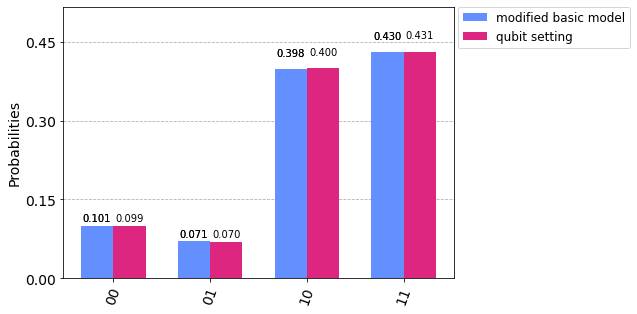

In [27]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=100000)
counts=job.result().get_counts()
plot_histogram([countsMod[2],counts],legend=['modified basic model','qubit setting'])

#### Construction of Quantum Amplitude Estimation
- for a risk model, we are interested in the probability that the limit is reached
- for the circuit this is the probability that the limit qubit is 1
- this probability can be estimated with the Quantum Amplitued Estimation (QAE)
- we use the circuit with modification qubits for the construction
- in the first step, we use the circuit to construct a Grover operator
- we mark the state 1 in the qubit at the bottom with the phase -1 as this marks the states that correspond to reaching the limit
- note that the qubits on the top corresponding to the modifications qubits should not be changed by phases in the construction of the Grover operator

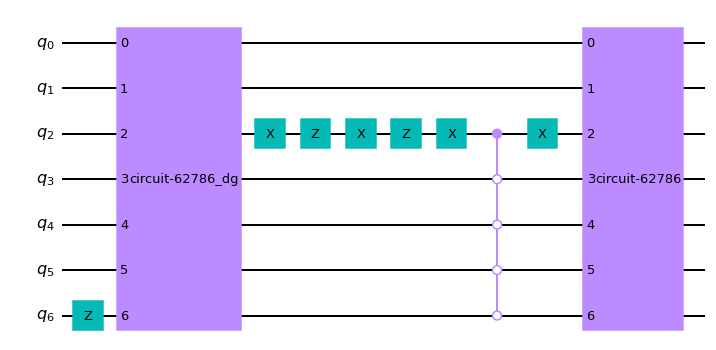

In [28]:
grover=constructGroverOperatorForRiskModelWithLimit(model,requiredQubits)
grover.draw(output='mpl')

- this Grover operator can be used for constructing the QAE circuit
- we can choose the number of bits that define the precision (resolution) of the QAE

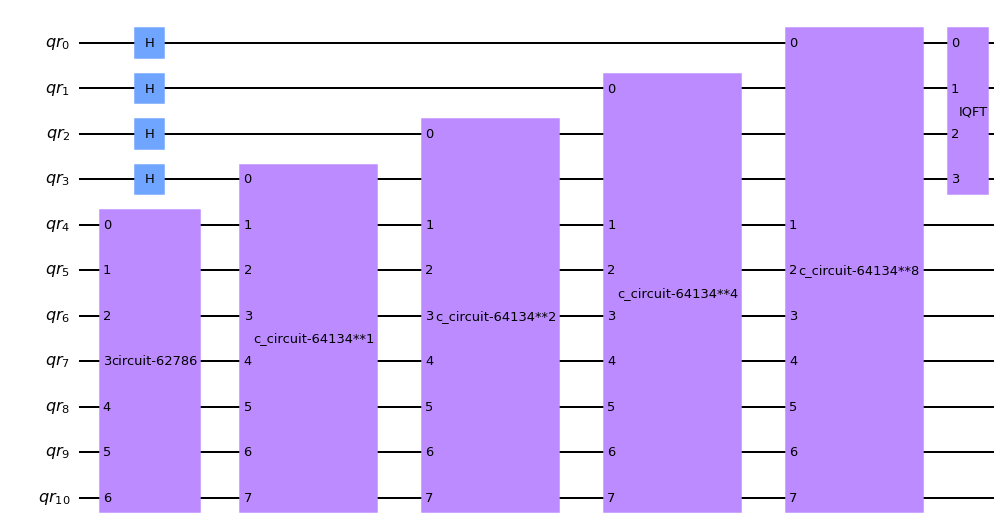

In [29]:
resolution=4
qae=circuitStandardQAEnoMeasurement(model, grover, resolution)
qae.draw(output='mpl')

- for testing, we can use the QAE circuit for estimating the probabilities with different settings of the modification qubits
- we compare the model with the settings '00' and '10' of the modification qubits
- this correspond to the probabilities 0.26 and .43 of reaching the limit, respectively
- for a resolution of 4 qubits these probabilities are closest to the QAE outputs 0.3087 and 0.5, respectively

In [30]:
# Run QAE circuit without modification.

qr=QuantumRegister(model.num_qubits+resolution,'q')
cr=ClassicalRegister(resolution,'c')
qc=QuantumCircuit(qr,cr)
qc.append(qae,qr)
qc.measure(qr[:resolution],cr)

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=100)
counts=job.result().get_counts()
probs00=getHistogramProbabilityValues(counts)

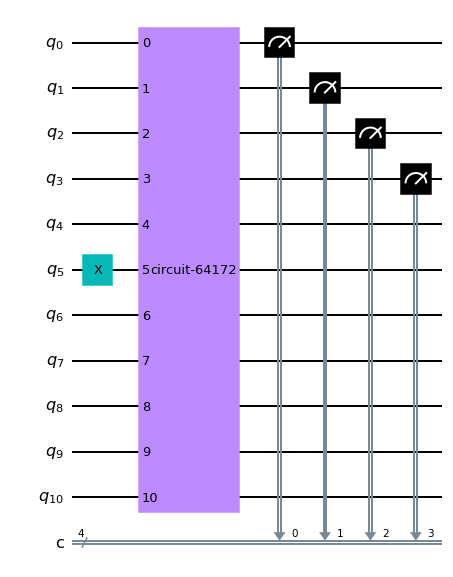

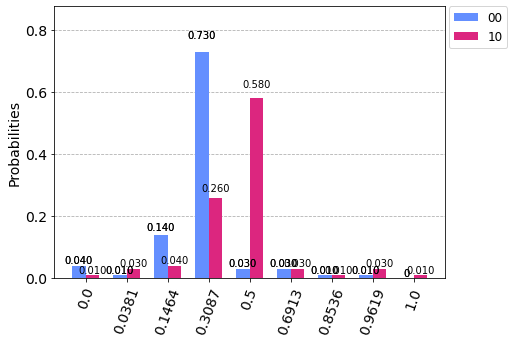

In [31]:
# Run QAE circuit with modification 10.

qr=QuantumRegister(model.num_qubits+resolution,'q')
cr=ClassicalRegister(resolution,'c')
qc=QuantumCircuit(qr,cr)
qc.x(qr[resolution+1])
qc.append(qae,qr)
qc.measure(qr[:resolution],cr)
display(qc.draw(output='mpl'))

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=100)
counts=job.result().get_counts()
probs10=getHistogramProbabilityValues(counts)

plot_histogram([probs00,probs10],legend=['00','10'])

#### Sensitivity analysis
- from the basic model without modifications we know that the probability of reaching the limit is 0.26
- as an example for a sensitivity analysis, we want to find out if a modification leads to a probability
close to 0.5
- we run the QAE circuit and mark the qubit on the top with the phase -1 for the chosen QAE result
- the QAE results that correspond to the target probability 0.5 are calculated automatically for the chosen resolution
- if the chosen probability does not match exactly a result of QAE then the closest possible value is chosen
- we run the inverse QAE circuit after marking the first qubit to obtain an operator suitable for Grover search

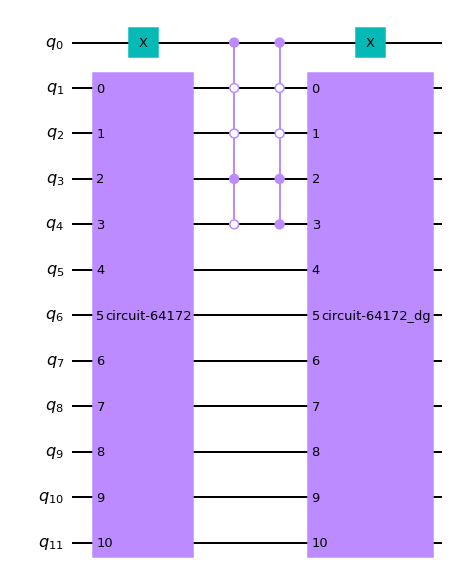

In [32]:
targetProb=0.5
qc=getGroverOracleFromQAEoracle(len(model.qubits)+resolution, qae, resolution, targetProb)
qc.draw(output='mpl')

- with this operator we can construct a Grover search on the modification qubits
- for example, we can construct the circuit for Grover search with one step

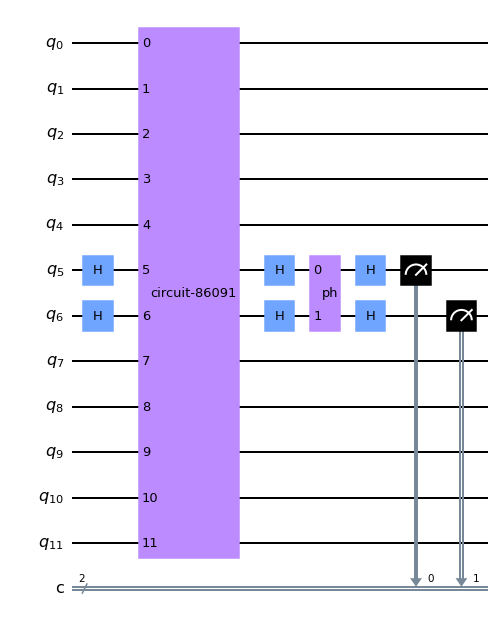

In [33]:
iterations=1
qc=circuitGroverOverQAE(iterations, len(model.qubits)+resolution, qae, resolution, requiredQubits, targetProb)
qc.draw(output='mpl')

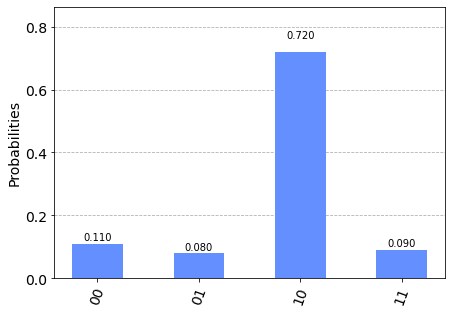

In [34]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend,shots=100)
counts=job.result().get_counts()
plot_histogram(counts)

- for testing, we run a series of circuits to see the probability for obtaining the result '10' 
- we consider 0 to 5 Grover steps

In [35]:
searched='10'
indices=[]
goodCounts=[]
goodLabels=[]

for iterations in range(6):
    qc=circuitGroverOverQAE(iterations, len(model.qubits)+resolution, qae, resolution, requiredQubits, targetProb)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend,shots=1000)
    counts=job.result().get_counts()
    print(iterations,counts)
    rate=0
    if searched in counts:
        rate=counts[searched]/1000
    indices.append(iterations)
    goodCounts.append(counts)
    goodLabels.append(str(iterations)+"Grover ops.")

0 {'01': 236, '11': 242, '00': 267, '10': 255}
1 {'01': 65, '11': 90, '00': 61, '10': 784}
2 {'01': 232, '11': 227, '10': 277, '00': 264}
3 {'11': 247, '01': 274, '00': 266, '10': 213}
4 {'01': 80, '00': 121, '10': 739, '11': 60}
5 {'01': 249, '11': 207, '00': 300, '10': 244}


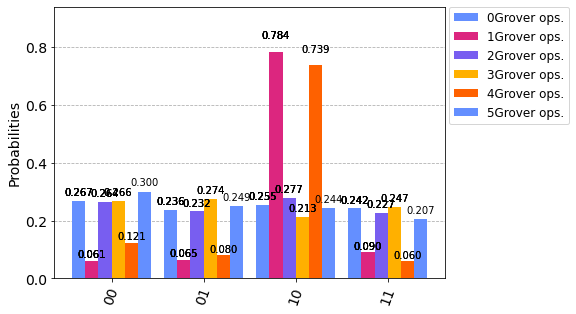

In [36]:
plot_histogram(goodCounts,legend=goodLabels)